## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Loading the dataset

In [ ]:
import pandas as pd
import json

In [ ]:
file = '/content/drive/MyDrive/Amazon megazine data sentiment analysis/Magazine_Subscriptions.jsonl'

In [ ]:
megazine_data = []
with open(file, 'r') as fp:
    for line in fp:
        obj = json.loads(line.strip())

        # Extract the 'rating' and 'review' fields
        text = obj.get('text')   # Replace with the actual key for rating
        rating = obj.get('rating')   # Replace with the actual key for review

        # Append the extracted fields to the data list
        megazine_data.append({'text': text, 'rating': rating})

# Create a DataFrame from the list of dictionaries
megazine_data = pd.DataFrame(megazine_data)
megazine_data.head()

,text,rating
0,Wonderful recipes in this magazine.,5.0
1,Great sports magazine that's on my 9 year olds...,4.0
2,"""Joy of Kosher"" magazine fills a much-needed n...",5.0
3,I've been addicted to Martha Stewart's Everyda...,5.0
4,Too many ads!,1.0


## Saving as csv for future use

In [ ]:
megazine_data.to_csv('/content/drive/MyDrive/Amazon megazine data sentiment analysis/megazine_data.csv')

## Inspecting the data

In [ ]:
megazine_data.shape

(71497, 2)

In [ ]:
megazine_data.head()

## Checking for null values

In [ ]:
megazine_data.isna().sum()

,0
text,0
rating,0


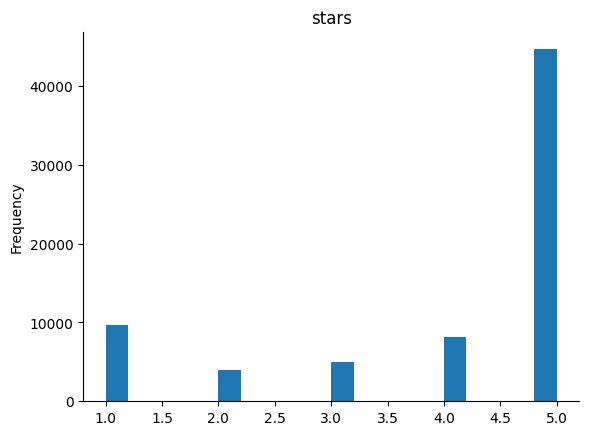

In [ ]:
# @title Rating

from matplotlib import pyplot as plt
megazine_data['rating'].plot(kind='hist', bins=20, title='stars')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Get sentiment scores based on the user given ratings

In [ ]:
def get_sentiment(stars):
  if stars <= 2:
    return 0
  elif stars == 3:
    return 1
  elif stars >= 4:
    return 2

### Apply the get_sentiment function

In [ ]:
megazine_data['sentiment'] = megazine_data['rating'].apply(get_sentiment)

In [ ]:
megazine_data.head()

,text,rating,sentiment
0,Wonderful recipes in this magazine.,5.0,2
1,Great sports magazine that's on my 9 year olds...,4.0,2
2,"""Joy of Kosher"" magazine fills a much-needed n...",5.0,2
3,I've been addicted to Martha Stewart's Everyda...,5.0,2
4,Too many ads!,1.0,0


## Class distribution after mapping sentiments

In [ ]:
megazine_data['sentiment'].value_counts()

,count
sentiment,
2,52826
0,13638
1,5033


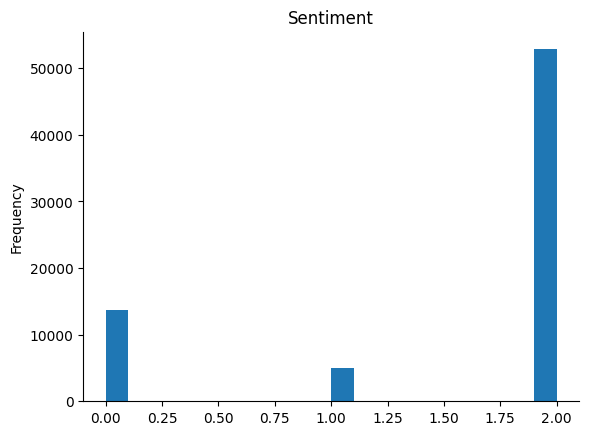

In [ ]:
# @title Sentiment

from matplotlib import pyplot as plt
megazine_data['sentiment'].plot(kind='hist', bins=20, title='Sentiment')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Data preprocessing

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# STOPWORD REMOVAL
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in text.split() if word not in stop_words]
    return ' '.join(filtered_words)

# LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

def lemmatizer(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [wl.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)


def preprocess_text(text):
  # text = str(text)
  text = text.lower()
  text = text.strip()

  # Remove URLs/links
  text = re.sub(r'http\S+|www.\S+', '', text)
  text = re.sub(r'\(.*?\)|\[.*?\]', '', text)
  text = re.sub(r'[\(\)\[\]]', '', text)
  text = re.compile('<.`/*?>').sub('', text)
  text = re.sub(r'\[[0-9]*]', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  text = re.sub(r'\s+', ' ', text)
  return text

In [ ]:
def final_preprocess(texts):
  texts = [preprocess_text(text) for text in texts] # Apply preprocess_text to each text in the list
  # texts = [remove_stopwords(text) for text in texts] # Apply remove_stopwords to each text in the list
  texts = [lemmatizer(text) for text in texts]  # Apply lemmatizer to each text in the list
  return texts

## Preprocessing pipeline

In [ ]:
# Define a function to apply preprocessing and splitting
def apply_pipeline(texts):
    pipeline = Pipeline([
        ('preprocessor', FunctionTransformer(lambda x: final_preprocess(x), validate=False)),
    ])

    # Fit and transform the data
    X_transformed = pipeline.fit_transform(texts)
    return X_transformed

## Resampler function

In [ ]:
def resampler(X, y):
  ro = RandomOverSampler()
  X, y = ro.fit_resample(X, y)
  return X, y

## GloVe vectorizer function

In [ ]:
import numpy as np

def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

# Load GloVe embeddings
glove_file = '/content/drive/MyDrive/Amazon megazine data sentiment analysis/glove.6B.100d.txt'
embeddings_index = load_glove_embeddings(glove_file)

In [ ]:
def text_to_glove_vector(text, embeddings_index, embedding_dim=100):
    words = text.split()
    word_vectors = [embeddings_index.get(word, np.zeros(embedding_dim)) for word in words if word in embeddings_index]

    # Return the average of the word vectors (single sentence vector)
    return np.mean(word_vectors, axis=0) if len(word_vectors) > 0 else np.zeros(embedding_dim)

def dataset_to_glove(X, embeddings_index, embedding_dim=100):
    return np.array([text_to_glove_vector(text, embeddings_index, embedding_dim) for text in X])

## Splitter function

In [ ]:
def splitter(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  return X_train, X_test, y_train, y_test

## Applying preprocessing pipeline

In [ ]:
X_transformed = apply_pipeline(megazine_data['text'])

In [ ]:
X_transformed

['wonderful recipe in this magazine',
 'great sport magazine thats on my year old level',
 'joy of kosher magazine fill a muchneeded niche for kosher recipe cookbook review and the kosher lifestyle not found in other mainstream magazine sporting beautifullyphotographed cover and spread that are equally at home next to powerhouse food and cooking magazine joy of kosher is your source for all thing kosher far beyond mere recipe joy of kosher includes news on kosher restaurant kosher wine cookbook kitchen tool holiday decorating tip and article on kosher travel youll read interview with kosher chef and entrepreneur and spotlight on new kosher product kosher wine and wine pairing are given plenty of space there are dozen of upandcoming kosher winery in israel and many toprated wine among thembr br more than just a cooking magazine joy of kosher is a lifestyle magazine sure the emphasis is on kosher food and wine but youll also find article on food and health family outingsactivities and tr

## Obtaining GloVe vectors

In [ ]:
x_transformed = dataset_to_glove(X_transformed, embeddings_index, embedding_dim=100)

## Resampling

In [ ]:
X, y = resampler(x_transformed, megazine_data['sentiment'])

## Number of ratings per sentiment after resampling

In [ ]:
y.value_counts()

,count
sentiment,
2,52826
0,52826
1,52826


## Splitting

In [ ]:
X_train, X_test, y_train, y_test = splitter(X, y)

## Class distribution of training and testing sets

In [ ]:
y_train.value_counts()

,count
sentiment,
2,42412
0,42199
1,42171


In [ ]:
y_test.value_counts()

,count
sentiment,
1,10655
0,10627
2,10414


## How the vectorized data looks like

In [ ]:
X_train

array([[-0.2108864 ,  0.19374999,  0.04096401, ..., -0.26959801,
         0.4071826 ,  0.349278  ],
       [-0.10410296,  0.24428022,  0.20118603, ..., -0.41685912,
         0.47113246,  0.26505703],
       [-0.3631804 ,  0.379498  ,  0.16866438, ..., -0.67806399,
         0.60154402,  0.547189  ],
       ...,
       [-0.16721624,  0.25778061,  0.38698664, ..., -0.38313615,
         0.46400383,  0.24200121],
       [-0.0407083 ,  0.17861749,  0.38122812, ..., -0.21474735,
         0.69100457,  0.0252439 ],
       [-0.12713285,  0.27180976,  0.39737773, ..., -0.32892552,
         0.4853878 ,  0.31082478]])

In [ ]:
X_test

array([[-0.01966619,  0.17723985,  0.2609438 , ..., -0.32061771,
         0.53035593,  0.33431527],
       [-0.23119561,  0.32096499,  0.34605414, ..., -0.35614824,
         0.24429151,  0.27128485],
       [-0.12218714,  0.25989464,  0.39080718, ..., -0.37603614,
         0.40493613,  0.29022187],
       ...,
       [-0.10675456,  0.29212111,  0.35409105, ..., -0.39003459,
         0.48491797,  0.21834882],
       [-0.07957727,  0.22656155,  0.36646342, ..., -0.26645145,
         0.35068777,  0.35378453],
       [-0.24736667,  0.20211233,  0.77624995, ..., -0.20898934,
        -0.03142   ,  0.36343002]])

## Checking the dimensions

In [ ]:
X_train.shape

(126782, 100)

In [ ]:
X_test.shape

(31696, 100)

## Model training and testing

In [ ]:
import tensorflow as tf

In [ ]:
# defined to preprocess a single review during testing

import re, string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# STOPWORD REMOVAL
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in text.split() if word not in stop_words]
    return ' '.join(filtered_words)

# LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()

def lemmatizer(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [wl.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)


def process(text):
  # text = str(text)
  text = text.lower()
  text = text.strip()

  # Remove URLs/links
  text = re.sub(r'http\S+|www.\S+', '', text)
  text = re.sub(r'\(.*?\)|\[.*?\]', '', text)
  text = re.sub(r'[\(\)\[\]]', '', text)
  text = re.compile('<.`/*?>').sub('', text)
  text = re.sub(r'\[[0-9]*]', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\d+', '', text)
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
  text = re.sub(r'\s+', ' ', text)

  # text = remove_stopwords(text)
  text = lemmatizer(text)
  return [text]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reshaping as a tensor

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## Converting into one-hot encoded categorical labels

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Function to create the model

In [ ]:
def create_model():
  inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
  gru = tf.keras.layers.GRU(128, return_sequences=True)(inputs)
  gru = tf.keras.layers.GRU(64)(gru)
  outputs = tf.keras.layers.Dense(3, activation='softmax')(gru)
  model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
  print(model.summary())
  return model

In [ ]:
dl_model = create_model()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1, 100)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 1, 128)              │          88,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 125,763 (491.26 KB)

 Trainable params: 125,763 (491.26 KB)

 Non-trainable params: 0 (0.00 B)

None


## Compiling

In [ ]:
dl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy', dtype=None),
                  tf.keras.metrics.Recall(name='Recall'),
                  tf.keras.metrics.Precision(name='Precision')])

## Training with validation and early stopping

In [ ]:
history = dl_model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

Epoch 1/50
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - Precision: 0.6996 - Recall: 0.4092 - accuracy: 0.5971 - loss: 0.8516 - val_Precision: 0.7017 - val_Recall: 0.5189 - val_accuracy: 0.6377 - val_loss: 0.7855
Epoch 2/50
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - Precision: 0.7016 - Recall: 0.5410 - accuracy: 0.6449 - loss: 0.7760 - val_Precision: 0.7061 - val_Recall: 0.5722 - val_accuracy: 0.6569 - val_loss: 0.7555
Epoch 3/50
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - Precision: 0.7121 - Recall: 0.5657 - accuracy: 0.6609 - loss: 0.7524 - val_Precision: 0.7182 - val_Recall: 0.5761 - val_accuracy: 0.6673 - val_loss: 0.7367
Epoch 4/50
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - Precision: 0.7152 - Recall: 0.5790 - accuracy: 0.6671 - loss: 0.7396 - val_Precision: 0.7213 - val_Recall: 0.5981 - val_accuracy: 0.6759 - val_loss: 0.7195
Epoch 5/50
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - Precision: 0.7239 - Recall: 0.5977 - accuracy: 0.6760 - loss: 0.7210 - val_Precision: 0.743

## Testing and evaluation

In [ ]:
dl_model.evaluate(X_test, y_test)

991/991 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Precision: 0.9091 - Recall: 0.8945 - accuracy: 0.9033 - loss: 0.3367


[0.33482444286346436,
 0.9008708000183105,
 0.8922261595726013,
 0.9071371555328369]

## Plotting accuracy and loss curves

In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Accuracy')

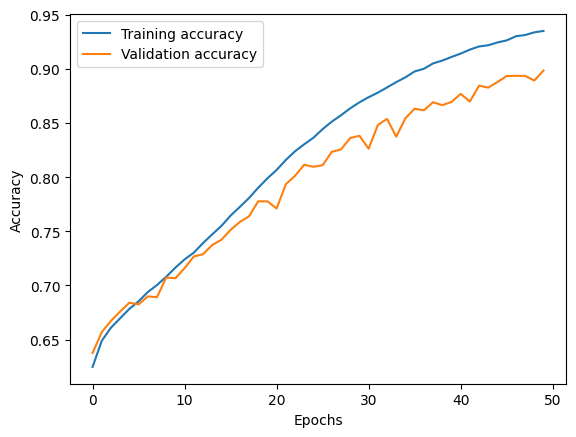

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training accuracy','Validation accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

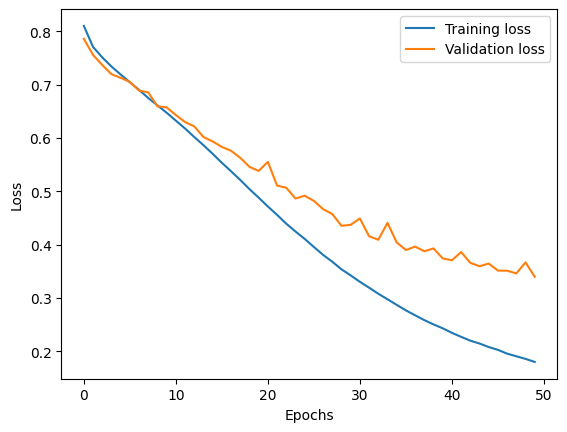

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training loss','Validation loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")

## Testing with single reviews

In [ ]:
processed_text = dataset_to_glove(process("very bad"), embeddings_index, embedding_dim=100)
print(processed_text, processed_text.shape)
processed_text = processed_text.reshape(processed_text.shape[0], 1 ,processed_text.shape[1])
print(processed_text, processed_text.shape)
prediction_dl = dl_model.predict(processed_text)

[[-3.6656499e-01  4.2363000e-01  4.7158501e-01 -2.1565500e-01
  -5.7955503e-01 -1.4096400e-01 -2.3611999e-01 -4.2769998e-02
  -1.7333001e-01 -1.0045500e-01 -1.1898400e-01 -2.7160999e-01
   2.8402001e-01 -3.0548000e-01 -1.7458500e-01  7.6699987e-02
  -4.2832500e-01 -2.6959500e-01 -1.3935801e-01  7.2104502e-01
   6.2059498e-01  1.9960999e-01  2.3532000e-01 -1.0768501e-01
  -5.5212501e-02 -2.3747002e-01 -2.5906000e-01 -5.7844996e-02
  -4.2190000e-02  2.3910001e-02 -1.0714993e-02  8.4199995e-02
   2.4602500e-01  5.6405008e-02  1.2182501e-01 -8.8525012e-02
  -1.9284400e-01 -7.0105009e-02 -6.9723003e-02 -1.1344500e-01
  -3.8198000e-01  2.9692051e-01  2.9722500e-01 -1.8223800e-01
   3.8374999e-01  3.6842000e-01  9.8909998e-01 -6.4704999e-02
  -2.5275502e-01 -9.9651003e-01  1.1293500e-01 -4.2777002e-01
   3.0409992e-02  9.3561500e-01 -2.6222500e-01 -2.4273500e+00
   4.6425003e-01  3.0734950e-01  1.4433000e+00  3.7218001e-01
  -4.3536600e-01  1.1519850e+00 -8.3090997e-01 -3.1136000e-01
   8.390

In [ ]:
prediction_dl

array([[9.9998534e-01, 1.4683677e-05, 3.5730689e-11]], dtype=float32)

In [ ]:
prediction_dl.argmax()

0

## Function to map sentiment from prediction

In [ ]:
def map_sentiment(prediction):
  if prediction == 0:
    return 'Negative'
  elif prediction == 1:
    return 'Neutral'
  elif prediction == 2:
    return 'Positive'

In [ ]:
sentiment = map_sentiment(prediction_dl.argmax())

In [ ]:
sentiment

## Saving for deployment

In [ ]:
dl_model.save('/content/drive/MyDrive/Amazon megazine data sentiment analysis/dl_model.keras')